In [1]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
# import seaborn
# plt.style.use('seaborn-white')
from pathlib import Path


import matplotlib.cm as cm
from IPython.display import Image
import git

In [2]:
from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

 ### Save the species pictures for a model (renaming with species names instead of smiles

In [3]:
# get the current git repo
import git
repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia/')
# repo.git.checkout('master')
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:20].replace(" ", "_").replace("'", "_")
commit_folder = git_sha + "_" + git_msg
print(commit_folder)

# save the pictures for molecules in the RMG run
overwrite = False
commit = commit_folder
dictionary_filename = "/work/westgroup/lee.ting/cantera/ammonia/base/chemkin/species_dictionary.txt"
specs = Database().get_species(dictionary_filename, resonance=False)

images_dir = os.path.join(f"/work/westgroup/lee.ting/cantera/ammonia_analysis/{commit}/species_pictures")
os.makedirs(images_dir, exist_ok=True)
for name, species in specs.items():
    filepath = os.path.join(images_dir, name + ".png")
    if not overwrite and os.path.exists(filepath):
        continue
    species.molecule[0].draw(filepath)

b027c2_added_base_folder_wi


### Convert dot files to prettydot (dot with molecule structure)

In [4]:
def prettydot(commit_path, dotfilepath, strip_line_labels=False):
    """
    Make a prettier version of the dot file (flux diagram)

    Assumes the species pictures are stored in a directory
    called 'species_pictures' alongside the dot file.
    """
    import os, sys, re
    import subprocess
    import git
    
#     use git to get picture directory
#    repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia_analysis')
#    git_sha = str(repo.head.commit)[0:6]
#    git_msg = str(repo.head.commit.message)[0:20].replace(" ", "_").replace("'", "_")
#    commit_folder = git_sha + "_" + git_msg
    
    
    
    pic_dir = f"{commit_path}/species_pictures/"
    pictures_directory = pic_dir

    if strip_line_labels:
        print("stripping edge (line) labels")

    reSize = re.compile('size="5,6"\;page="5,6"')
    reNode = re.compile(
        '(?P<node>s\d+)\ \[\ fontname="Helvetica",\ label="(?P<label>[^"]*)"\]\;'
    )

    rePicture = re.compile("(?P<smiles>.+?)\((?P<id>\d+)\)\.png")
    reLabel = re.compile("(?P<name>.+?)\((?P<id>\d+)\)$")

    species_pictures = dict()
    for picturefile in os.listdir(pictures_directory):
        match = rePicture.match(picturefile)
        if match:
            species_pictures[match.group("id")] = picturefile
        else:
            pass
            # print(picturefile, "didn't look like a picture")

    filepath = dotfilepath

    if not open(filepath).readline().startswith("digraph"):
        raise ValueError("{0} - not a digraph".format(filepath))

    infile = open(filepath)
    prettypath = filepath.replace(".dot", "", 1) + "-pretty.dot"
    outfile = open(prettypath, "w")

    for line in infile:
        (line, changed_size) = reSize.subn('size="12,12";page="12,12"', line)
        match = reNode.search(line)
        if match:
            label = match.group("label")
            idmatch = reLabel.match(label)
            if idmatch:
                idnumber = idmatch.group("id")
                if idnumber in species_pictures:
                    line = (
                        f'%s [ image="{pic_dir}%s" label="" width="0.5" height="0.5" imagescale=false fixedsize=false color="none" ];\n'
                        % (match.group("node"), species_pictures[idnumber])
                    )

        # rankdir="LR" to make graph go left>right instead of top>bottom

        if strip_line_labels:
            line = re.sub('label\s*=\s*"\s*[\d.]+"', 'label=""', line)

        # change colours
        line = re.sub('color="0.7,\ (.*?),\ 0.9"', r'color="1.0, \1, 0.7*\1"', line)

        outfile.write(line)

    outfile.close()
    infile.close()
    print(f"Graph saved to: {prettypath}")
    os.system(f'dot {prettypath} -Tpng -o{prettypath+".png"} -Gdpi=200')
    return prettypath

# read in each filename into dictionary. 
for path in Path('../').rglob('*.dot'):
    path_str = str(path)
    start_index = path_str.find(f'../cantera/ammonia_analysis/{commit_folder}')
    
    if start_index != -1:
        commit = path_str[(start_index+13):(start_index+40)]
        path = path_str
        print(path)
        print(commit)
        prettydot(commit, path, strip_line_labels=False)

## Git-python: checkout master branch

In [10]:
import git
repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia/')
# repo.git.checkout('master')
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:20].replace(" ", "_").replace("'", "_")
print(git_sha,': ', git_msg)

current_commit = git_sha+"_"+git_msg

b027c2 :  added_base_folder_wi


## checkout 1 commit back

In [6]:
# repo.git.checkout('HEAD^1')
# sha = str(repo.head.commit)
# msg = str(repo.head.commit.message)
# print(sha,': ', msg)

## checkout 2 commits back

In [7]:
# repo = git.Repo('/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/')
# repo.git.checkout('HEAD^1')
# sha = repo.head.commit
# msg = repo.head.commit.message
# print(sha,': ', msg)

## Read in data

In [14]:
commit_list = []

# read in each filename into dictionary. 
for path in Path('../').rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find('../ammonia_analysis/')
    
    if start_index != -1:
        commit = path_str[(start_index+13):(start_index+40)]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   
# os.remove("endrxncsv.csv")

['alysis/b027c2_added_base_fo']


In [15]:
# read last line from each CSV file
data_dict = {}
# if true, runs analysis on current commit only
one_commit = True
if one_commit == True:
    commit_list = [current_commit]
    

for commit in commit_list:
    first_file = True
    for path in Path('../ammonia_analysis/' + commit).rglob('*.csv'):
        
        path_str = str(path)
        if "/csp/" not in path_str and "/steady_state/" not in path_str:
            if os.stat(path_str).st_size != 0:
                if first_file == True: 
                    data = pd.read_csv(path_str)
                    aggdata = data.tail(1)
                    first_file = False
                    print('ran')
                else: 
                    data = pd.read_csv(path_str)
                    aggdata = aggdata.append(data.tail(1))
                    print(len(aggdata))
                    print(path)
            
    data_dict.update({commit:aggdata})

ran
2
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/400/results/Spinning_basket_area_0.0146_energy_off_temp_400_O2_0_8_NH3_0_005999.csv
3
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/400/results/Spinning_basket_area_3.96e-06_energy_off_temp_400_O2_0_1_NH3_0_02475.csv
4
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/400/results/Spinning_basket_area_3.96e-06_energy_off_temp_400_O2_0_1_NH3_0_0405.csv
4
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/400/results/Spinning_basket_area_3.96e-06_energy_off_temp_400_O2_0_1_NH3_0_05625.csv
5
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/400/results/Spinning_basket_area_3.96e-06_energy_off_temp_400_O2_0_1_NH3_0_072000.csv
6
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/400/results/Spinning_basket_area_3.96e-06_energy_off_temp_400_O2_0_1_NH3_0_087750.csv
7
../ammonia_analysis/b027c2_a

52
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/550/results/Spinning_basket_area_3.96e-06_energy_off_temp_550_O2_0_3_NH3_0_0805.csv
53
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/550/results/Spinning_basket_area_3.96e-06_energy_off_temp_550_O2_0_3_NH3_0_09275.csv
54
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/550/results/Spinning_basket_area_3.96e-06_energy_off_temp_550_O2_0_3_NH3_0_105.csv
55
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/550/results/Spinning_basket_area_3.96e-06_energy_off_temp_550_O2_0_6_NH3_0_004.csv
56
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/550/results/Spinning_basket_area_3.96e-06_energy_off_temp_550_O2_0_6_NH3_0_011000.csv
57
../ammonia_analysis/b027c2_added_base_folder_wi/IdealGasReactor/transient/550/results/Spinning_basket_area_3.96e-06_energy_off_temp_550_O2_0_6_NH3_0_018.csv
58
../ammonia_analysis/b027c2_adde

In [17]:
# read last line from each CSV file
data_dict_ss = {}

# if true, runs analysis on current commit only
one_commit = True
if one_commit == True:
    commit_list = [current_commit]
    

for commit in commit_list:
    first_file = True
    for path in Path('../amonia_analysis/' + commit).rglob('*.csv'):
        
        path_str = str(path)
        if "/csp/" not in path_str and "/steady_state/" in path_str:
            if os.stat(path_str).st_size != 0:
                if first_file == True: 
                    data = pd.read_csv(path_str)
                    aggdata = data.tail(1)
                    first_file = False
                    print('ran')
                else: 
                    data = pd.read_csv(path_str)
                    aggdata = aggdata.append(data.tail(1))
                    print(len(aggdata))
                    print(path)
                    
    data_dict_ss.update({commit:aggdata})

## Turn over frequency comparison

The mechanisms listed below are the pathways that are of interest in TOF.



In [81]:
#Image('../images/Grabow_plots/Grabow_TOF.png',width = 700, height = 300)

[0.8 0.1 0.3 0.6 0.9]


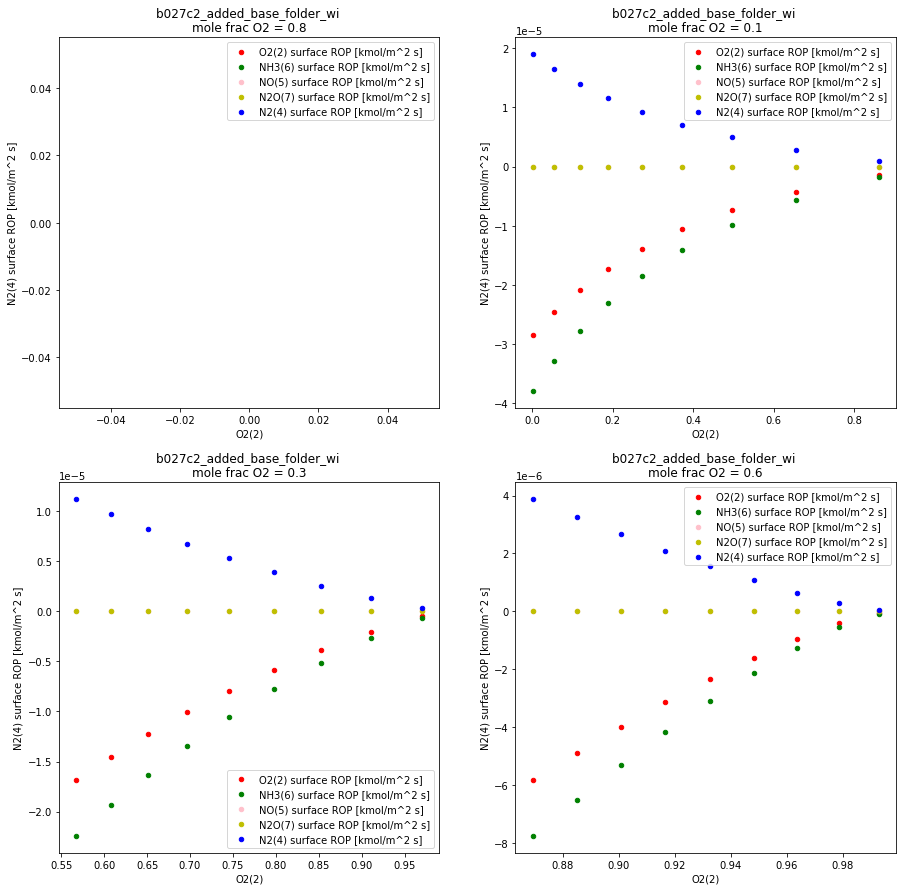

In [37]:
# compare the rate of production for NH3, O2, NO, N2O and N2

for commit in commit_list:
    #commit = 'b027c2_added_base_folder_wi'  

    conditions = ['O2(2) surface ROP [kmol/m^2 s]', 'NH3(6) surface ROP [kmol/m^2 s]',
                 'NO(5) surface ROP [kmol/m^2 s]', 'N2O(7) surface ROP [kmol/m^2 s]','N2(4) surface ROP [kmol/m^2 s]']
    temp = 550

    # get keys for O2 (X_o2 initial)
    o2_ratio = data_dict[commit_list[0]]['X_o2 initial'].unique()
    print(o2_ratio)

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"r", 1:"g", 2:"pink", 3:"y",4:"blue"}
    for p,j in enumerate(o2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='O2(2)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac O2 = {j}')
                ax[0,0].autoscale(enable=True, axis='y')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='O2(2)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac O2 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='O2(2)', y=i, label=i, ax =ax[1,0], color=color_dict[c])
                ax[1,0].set_title(f'{commit} \nmole frac O2 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='O2(2)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac O2 = {j}')

In [ ]:
# compare the rate of production for NH3, O2, NO, N2O and N2

for commit in commit_list:
    #commit = 'b027c2_added_base_folder_wi'  

    conditions = ['O2(2) surface ROP [kmol/m^2 s]', 'NH3(6) surface ROP [kmol/m^2 s]', \
                 'NO(5) surface ROP [kmol/m^2 s]', 'N2O(7) surface ROP [kmol/m^2 s]','N2(4) surface ROP [kmol/m^2 s]']
    temp = 550

    # get keys for O2 (X_o2 initial)
    o2_ratio = data_dict[commit_list[0]]['X_o2 initial'].unique()
    print(o2_ratio)

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"r", 1:"g", 2:"pink", 3:"y",4:"blue"}
    for p,j in enumerate(o2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='NH3(6)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac NH3 = {j}')
                ax[0,0].autoscale(enable=True, axis='y')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='NH3(6)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac NH3 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='NH3(6)', y=i, label=i, ax =ax[1,0], color=color_dict[c])
                ax[1,0].set_title(f'{commit} \nmole frac NH3 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_o2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='NH3(6)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac NH3 = {j}')

In [20]:
 data_dict[commit]

,T (C),P (atm),V (M^3/s),X_nh3 initial,X_o2 initial,X_he initial,(NH3/O2),T (C) final,Rtol,Atol,...,NO(5) + X(1) <=> NOX(27) ROP [kmol/m^2 s],NOX(27) + X(1) <=> NOX2(76) ROP [kmol/m^2 s],N2(4) + 2 X(1) <=> N2X2(25) ROP [kmol/m^2 s],N2X2(25) <=> 2 NX(59) ROP [kmol/m^2 s],NOX2(76) + NX(59) <=> N2X2(25) + OX(10) ROP [kmol/m^2 s],N2(4) + X(1) <=> N2X(26) ROP [kmol/m^2 s],N2X(26) + X(1) <=> N2X2(25) ROP [kmol/m^2 s],N2O2(46) + 2 X(1) <=> 2 NOX(27) ROP [kmol/m^2 s],O2X2(47) <=> 2 OX(10) ROP [kmol/m^2 s],NX(59) + O2X2(47) <=> NOX2(76) + OX(10) ROP [kmol/m^2 s]
9999,400,101325.0,2.720000e-02,0.00400,0.8,0,0.005000,400.0,1.000000e-11,1.000000e-22,...,-1.121758e-19,-1.040834e-17,-2.607883e-10,-3.780311e-08,1.414052e-13,-3.754247e-08,-3.754247e-08,-1.495997e-44,5.007418e-33,4.493404e-41
9999,400,101325.0,2.720000e-02,0.00600,0.8,0,0.007500,400.0,1.000000e-11,1.000000e-22,...,-1.119395e-19,1.387779e-17,-8.402626e-10,-8.502184e-08,3.179028e-13,-8.418190e-08,-8.418190e-08,-1.491087e-44,-3.466674e-33,1.009271e-40
9999,400,101325.0,2.715500e-08,0.02475,0.1,0,0.247500,400.0,1.000000e-11,1.000000e-22,...,-5.048751e-21,-2.678413e-15,-1.800934e-07,-2.896844e-06,1.081151e-11,-2.716761e-06,-2.716761e-06,-1.057089e-45,-5.122974e-32,3.428876e-39
9999,400,101325.0,2.715500e-08,0.04050,0.1,0,0.405000,400.0,1.000000e-11,1.000000e-22,...,-3.292204e-21,-2.775558e-16,-4.443840e-07,-4.939955e-06,1.774585e-11,-4.495589e-06,-4.495589e-06,-5.821138e-46,-1.425188e-32,5.421859e-39
9999,400,101325.0,2.715500e-08,0.07200,0.1,0,0.720000,400.0,1.000000e-11,1.000000e-22,...,-1.315966e-21,2.775558e-16,-1.350897e-06,-8.996275e-06,2.417659e-11,-7.645402e-06,-7.645402e-06,-1.321288e-46,3.659267e-33,5.527483e-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,700,101325.0,2.715500e-08,0.04600,0.6,0,0.076667,700.0,1.000000e-11,1.000000e-22,...,-3.660774e-10,-3.660784e-10,-2.439550e-07,-2.670277e-06,2.337075e-08,-2.449693e-06,-2.449693e-06,-9.435860e-25,3.308722e-24,2.716083e-24
9999,700,101325.0,2.715500e-08,0.05300,0.6,0,0.088333,700.0,1.000000e-11,1.000000e-22,...,-3.360641e-10,-3.360656e-10,-3.248838e-07,-3.272910e-06,2.861905e-08,-2.976645e-06,-2.976645e-06,-8.662482e-25,0.000000e+00,3.310171e-24
9999,700,101325.0,2.715500e-08,0.06000,0.6,0,0.100000,700.0,1.000000e-11,1.000000e-22,...,-3.113945e-10,-3.113957e-10,-4.165547e-07,-3.900433e-06,3.407650e-08,-3.517955e-06,-3.517955e-06,-8.011339e-25,-1.488925e-23,3.927821e-24
9999,700,101325.0,2.715500e-08,0.00100,0.9,0,0.001111,700.0,1.000000e-11,1.000000e-22,...,-1.156382e-09,-1.156382e-09,-2.366818e-11,-1.192054e-09,1.062325e-11,-1.179010e-09,-1.179010e-09,-1.431097e-24,-2.481542e-23,1.359685e-25


In [24]:
# get the maximum values for the 

max_dist = 2
imp_species = []

df_short = data_dict[commit_list[0]]

thresh = 1e-5

print(f'\nSpecies that have a concentration that goes above :{thresh}', '\n')
for i in range (13, len(df_short.columns)):
    
    column = df_short[df_short.columns[i]]
    max_value = column.max()
    max_index = column.idxmax()
    
    if max_value >= thresh and (("X" in df_short.columns[i]) or \
                              ("Pt" in df_short.columns[i]) or \
                              ("Pd" in df_short.columns[i]) or \
                              ("*" in df_short.columns[i])) \
    and not "ROP" in df_short.columns[i] \
    and not "sensitivity" in df_short.columns[i]:
            
        imp_species.append(df_short.columns[i])
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))



Species that have a concentration that goes above :1e-05 

X(1) Max = 0.9810128560
HX(9) Max = 0.0000533819
OX(10) Max = 0.9708882670
H2OX(14) Max = 0.0009666943
N2X2(25) Max = 0.4014404863
N2X(26) Max = 0.0351526613
NOX(27) Max = 0.2080597557
H2NX(28) Max = 0.0000155097
H3NX(29) Max = 0.6372327490
HNX(49) Max = 0.0044560621
NX(59) Max = 0.0001298428
NOX2(76) Max = 0.0001727866


In [25]:
# compare the rate of production for CO2,  H2O, CO, and CH3OH


# for commit in commit_list:
commit = commit_list[0] 

conditions = imp_species
temp = 400

# get keys for H2 (X_h2 initial)
H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()

fig, ax = plt.subplots(2,2,figsize=(15,15))

color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4:"c", 5:"m", 6: "k", 7: "lime" , 8:"brown"}
for p,j in enumerate(H2_ratio):
    if p == 0:
        for c,i in enumerate(conditions):
            data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
            ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
            ax[0,0].set_ylabel("Site Fraction")
    if p == 1:
        for c,i in enumerate(conditions):
            data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
            ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
            ax[0,1].set_ylabel("Site Fraction")
    if p == 2:
        for c,i in enumerate(conditions):
            data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],)
            ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
            ax[1,0].set_ylabel("Site Fraction")
    if p == 3:
        for c,i in enumerate(conditions):
            data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
            ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
            ax[1,1].set_ylabel("Site Fraction")

KeyError: 'X_h2 initial'

In [ ]:
for commit in commit_list:
# commit = 'a95dd5_added_new_family_sur'  

    conditions = ["CH3OH(8)"]

    temp = 500

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4:"c", 5:"m"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("Site Fraction")
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,1].set_ylabel("Site Fraction")
        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],)
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,0].set_ylabel("Site Fraction")
        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,1].set_ylabel("Site Fraction")

## Surface coverage comparison


In [ ]:
Image('../images/Grabow_plots/Grabow_coverage.png',width = 700, height = 300)

In [ ]:
for commit in commit_list:  

    # removing HCOO because we ar using the wrong species
    #     conditions = ['X(1)', 'H*(10)', 'CH3O*(20)', 'HCOO*(17)', 'OH*(12)']
    conditions = ['X(1)', 'H*(10)', 'HCOO*(17)', 'OH*(12)']
    
    temp = 500

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()

    fig, ax = plt.subplots(2,2,figsize=(15,13))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4: "k"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],ylim=[-0.1,1.0])
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (C)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')

## flux diagrams

In [ ]:
Image('../images/Grabow_plots/Grabow_rxn_path.png',width = 500, height = 300)

In [ ]:
Image('../images/Reaction_mechanism_alternative.png',width = 700, height = 300)

description of commits: 


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import math

%matplotlib inline
img = []
flux_path = []

# determine # of rows and columns for displays
placeholder = [1,2,3,4,5]



if one_commit == False:
    rcParams['figure.figsize'] = 40 ,40
    if len(commit_list)%2 == 0:
        rows = int(len(commit_list)/2)
    else: 
        rows = int(math.ceil(len(commit_list)/2))

    fig, ax = plt.subplots(rows,2)
    for i,commit in enumerate(commit_list):
        temp = 600 
        H2_frac = "0_5"
        CO_CO2 = "0_9"
        element = "C"
        phase = "surface1" # "surface1" "gas"
        time = "end" # "end" "beginning"
        prefix = '../RMG_wDeut/'
        flux_path.append(f'/IdealGasConstPressureReactor/{temp}/flux_diagrams/{H2_frac}/{CO_CO2}/reaction_path_{element}_{phase}_{time}-pretty.dot.png')


        img.append(mpimg.imread(f'{prefix}{commit}{flux_path[i]}'))

        #determine placement of picture
        if i%2 == 0:
            row = int(i/2)-1
            col = 0
        else:
            row = int(math.ceil(i/2)) - 1
            col = 1

        ax[row,col].imshow(img[i])
        ax[row,col].get_xaxis().set_visible(False) 
        ax[row,col].get_yaxis().set_visible(False) 
        ax[row,col].set_title(f'{commit}', fontsize = 30)
        
else:
    rcParams['figure.figsize'] = 10 ,10
    fig, ax = plt.subplots(1,1)
    for i,commit in enumerate(commit_list):
        temp = 500 
        H2_frac = "0_5"
        CO_CO2 = "0_9"
        element = "C"
        phase = "surface1" # "surface1" "gas"
        time = "end" # "end" "beginning"
        prefix = '../RMG_wDeut/'
        flux_path.append(f'/IdealGasReactor/transient/{temp}/flux_diagrams/{H2_frac}/{CO_CO2}/reaction_path_{element}_{phase}_{time}-pretty.dot.png')


        img.append(mpimg.imread(f'{prefix}{commit}{flux_path[i]}'))

        ax.imshow(img[i])
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
        ax.set_title(f'{commit}', fontsize = 30)



In [ ]:
Image('../images/Grabow_plots/Grabow_rxn_path.png',width = 500, height = 300)

### pathway analysis

In [ ]:
Image('../images/Grabow_plots/Grabow_PES.png',width = 1000, height = 300)

### sensitivity

In [ ]:
# load data into big data dictionary
sens_data_dict = {}
temps = [] 
X_h2s = []
X_coco2s = []

for path in Path('../RMG_wDeut/' + commit).rglob('*.csv'):
    path_str = str(path)
    if os.stat(path_str).st_size != 0 and "csp" not in path_str:
        data = pd.read_csv(path_str)
        if len(data['T (C)']) >= 1: 
            temp = float(data['T (C)'].unique())
            X_h2 = float(data['X_h2 initial'].unique())
            X_coco2 = round(float(data['CO2/(CO2+CO)'].unique()),1)

            if temp not in temps: temps.append(temp)
            if X_h2 not in X_h2s: X_h2s.append(X_h2) 

            if X_coco2 not in X_coco2s: X_coco2s.append(X_coco2)

            sens_data_dict.update({(temp,X_h2,X_coco2) : data})

        else:
            print(path_str)
            print("empty data, sim crashed")

        


In [ ]:
print(sens_data_dict.keys())

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 20), dpi=80)

def max_sensitivities(df, number=0):
    # make a dictionary of highest sensitivity (tuple?)
    columns = {}
    for key, value in df.iteritems():
        if "sensitivity" in key:
            max_sens = value.max()
            min_sens = value.min()
            
            if abs(max_sens) >= abs(min_sens):
                extreme_sens = max_sens
            elif abs(max_sens) < abs(min_sens):
                extreme_sens = min_sens
                
                
            columns.update({key:extreme_sens})
#             print(key, max_sens)

    if number !=0:
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True)[:number])
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False)[:number])
    else: 
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True))
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False))
    return columns, columns_rev


# plot the top sensitivities for a dataframe
def plot_sensitivities(df, num = 5, align="center", height=0.2, label = ""):
    
    imp_reactions_pos, imp_reactions_neg = max_sensitivities(df,num)
    imp_reactions = {**imp_reactions_pos, **imp_reactions_neg}

    imp_reactions_df = pd.Series(data = imp_reactions)
    imp_reactions_df.to_csv(f'test_{label}.csv')
    plt.barh(*zip(*imp_reactions.items()),height=height, log=True, align=align,alpha=0.8, label=label)
#     plt.show()

    plt.legend(loc='best')
#     imp_reactions_df.plot(kind='barh')

columns, columns_rev = max_sensitivities(sens_data_dict[400.0, 0.5, 0.9],5)

plot_sensitivities(sens_data_dict[400.0, 0.5, 0.5],10, "center", label="400K")
plot_sensitivities(sens_data_dict[500.0, 0.5, 0.5],10, "edge",label="500K")
plot_sensitivities(sens_data_dict[600.0, 0.5, 0.5],10, "edge", height=-0.2, label="600K")

In [ ]:
y = list(sens_data_dict.keys())
y[1][0]

In [ ]:
def max_sensitivities(df, number=0):
    # make a dictionary of highest sensitivity (tuple?)
    columns = {}
    for key, value in df.iteritems():
        if "thermo sensitivity" in key:
            max_sens = value.max()
            min_sens = value.min()
            
            if abs(max_sens) >= abs(min_sens):
                extreme_sens = max_sens
            elif abs(max_sens) < abs(min_sens):
                extreme_sens = min_sens
                
                
            columns.update({key:extreme_sens})

    if number !=0:
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True)[:number])
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False)[:number])
    else: 
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True))
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False))
    return columns, columns_rev


# plot the top sensitivities for a dataframe
def plot_sensitivities(df, num = 5):
    
    imp_reactions_pos, imp_reactions_neg  = max_sensitivities(df,num)
    imp_reactions = {**imp_reactions_pos, **imp_reactions_neg}
    
    plt.barh(*zip(*imp_reactions.items()))



columns, columns_rev = max_sensitivities(sens_data_dict[400.0, 0.5, 0.9],5)

plot_sensitivities(sens_data_dict[400.0, 0.5, 0.9],10)